**NOTE:** This notebook is copied from the following example: https://www.kaggle.com/sashr07/kaggle-titanic-tutorial

We will be exploring the titanic survival dataset. This is a dataset that contains information about the passengers on board of the titanic. We will analyze this dataset to see if we can come up with an algorithm that can successfully predict if someone would survive the titanic.

In [2]:
import pandas as pd

test = pd.read_csv('./test.csv')
test_shape = test.shape
print(test_shape)

(418, 11)


In [3]:
train = pd.read_csv('./train.csv')
train_shape = train.shape
print(train_shape)

(891, 12)


In [4]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


Does gender have some indication of who survived and who didn't?

In [5]:
import matplotlib.pyplot as plt

sex_pivot = train.pivot_table(index="Sex", values="Survived")

,Survived
Sex,
female,0.742038
male,0.188908


How about PClass? Does that correlated to survival on the titanic.

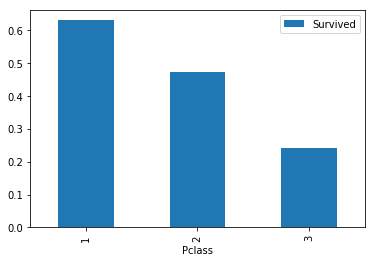

In [6]:
pclass_pivot = train.pivot_table(index="Pclass", values="Survived")
pclass_pivot.plot.bar()
plt.show()

Let's take a look at the age column to see how the data is structured.

In [7]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

We can create a histogram to help visualize the frequency of passenders that survived / died at certain ages.

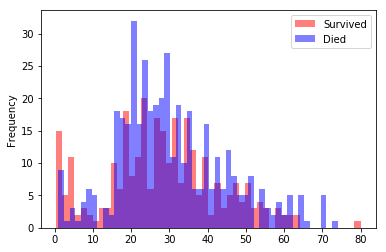

In [8]:
survived = train[train['Survived'] == 1]
died = train[train['Survived'] == 0]

survived['Age'].plot.hist(alpha=0.5, color='red', bins=50)
died['Age'].plot.hist(alpha=0.5, color='blue', bins=50)
plt.legend(['Survived', 'Died'])
plt.show()

For better processing, we will modify Age from a continuous value to a set of discrete classes.

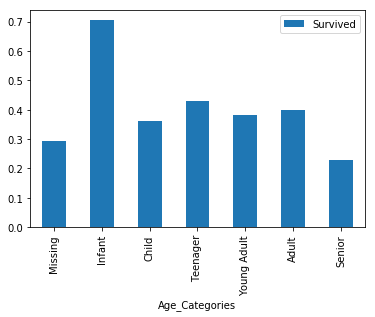

In [12]:
def process_age(df, cut_points, label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age_Categories"] = pd.cut(df["Age"], cut_points, labels=label_names)
    return df

cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

train = process_age(train, cut_points, label_names)
test = process_age(test, cut_points, label_names)

age_cat_pivot = train.pivot_table(index="Age_Categories", values="Survived")
age_cat_pivot.plot.bar()
plt.show()

So far we have identified three columns that may be useful for predicting survival:
    - Sex
    - Pclass
    - Age, or more specifically, our newly created Age_Categories
    
Before we are able to feed this into a machine-learning algorithm, we need to do some more pre-processing of the data. For example, Pclass has a numerical value, but the number has a categorical interpretation (Pclass 1 is not worth half of Pclass 2). To prevent our machine learning algorithm from making this association, we will use one-hot encoding to generate 3 new colums from the Pclass column: Pclass_1, Pclass_2, and Pclass_3. These columns take values 0 or 1, indicating if the passenger belongs to that column.

Similar processing needs to be done before we can use the "Sex" or "Age_Category" of a passenger.

Below is a snippet example of how we will use the **pandas** library to create one-hot-encoded columns.

In [14]:
column_name = "Pclass"
df = train
dummies = pd.get_dummies(df[column_name], prefix=column_name)
dummies.head(5)

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


Now we will write a create_dummies operation to generate the dummy columns.

In [16]:
def create_dummies(df, column_name):
    dummies = pd.get_dummies(df[column_name], prefix=column_name)
    df = pd.concat([df, dummies], axis=1)
    return df;

train = create_dummies(train, "Pclass")
test = create_dummies(test, "Pclass")

train = create_dummies(train, "Age_Categories")
test = create_dummies(test, "Age_Categories")

train = create_dummies(train, "Sex")
test = create_dummies(test, "Sex")

train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Pclass_3,Age_Categories_Missing,Age_Categories_Infant,Age_Categories_Child,Age_Categories_Teenager,Age_Categories_Young Adult,Age_Categories_Adult,Age_Categories_Senior,Sex_female,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,1,0,0,0,0,1,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,0,0,0,0,0,1,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,1,0,0,0,0,1,0,0,1,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,0,0,0,0,1,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,1,0,0,0,0,1,0,0,0,1


We have now prepped our data and are now ready to create a machine learning model. We will use the scikit-learn library to create our model.

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

columns = [
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_female',
    'Sex_male',
    'Age_Categories_Missing',
    'Age_Categories_Infant',
    'Age_Categories_Child',
    'Age_Categories_Teenager',
    'Age_Categories_Young Adult',
    'Age_Categories_Adult',
    'Age_Categories_Senior',
]
lr.fit(train[columns], train['Survived'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Kaggle has provded us with a training dataset and a test dataset to use. The testing dataset does not have the Survived column since the result we send to Kaggle will be predicting based on the values of that column.

However, we would like to get a sense or how accurate our model is without having to submit our solution to Kaggle every time. One option is to test how accurate our model is on the data we trained on, but this is not a great option, since our model will most likely perform well on the data is has already seen. We want to get a sense of how well our model does against data it has never seen. To do this, we can split our test data into data that we use to train our model and data that we use to test how accurate our model is.

In [23]:
from sklearn.model_selection import train_test_split

columns = [
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_female',
    'Sex_male',
    'Age_Categories_Missing',
    'Age_Categories_Infant',
    'Age_Categories_Child',
    'Age_Categories_Teenager',
    'Age_Categories_Young Adult',
    'Age_Categories_Adult',
    'Age_Categories_Senior',
]
all_X = train[columns]
all_y = train['Survived']

train_X, test_X, train_y, test_y = train_test_split(
    all_X,
    all_y,
    test_size=0.2,
    random_state=0)

train_X.shape

(712, 15)

We will now train our model on the new training data and test the accuracy of the data on our test data.

In [24]:
lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)

There are a number of ways to measure the accuracy of machine learning models, but when competing in Kaggle competitions you want to make sure you use the same method that Kaggle uses to calculate accuracy for that specific competition.

In this case, the evaluation section for the Titanic compeition on Kaggle tells us that our score calculated as "the percentage of passengers correctly predicted". This is by far the most common form of accuracy for binary classification.

In [27]:
from sklearn.metrics import accuracy_score

lr = LogisticRegression()
lr.fit(train_X, train_y)
predictions = lr.predict(test_X)
accuracy = accuracy_score(test_y, predictions)
accuracy

0.8100558659217877

In [28]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(test_y, predictions)
pd.DataFrame(
    conf_matrix,
    columns=['Survived', 'Died'],
    index=[['Survived', 'Died']])

,Survived,Died
Survived,96,14
Died,20,49


The matrix above gives us a breakdown of true positive, true negative, false positive, and false negative rates. We can see that we have a total of 34 predictions that are incorrect (false positive + false negative)

Because our training and test sets are very small, there is a risk that we could be overfitting to our training data. To avoid this, we will use cross-validation to train our dataset.

The most common form of cross validation, and the one we will be using, is called k-fold cross validation. 'Fold' refers to each different iteration that we train our model on, and 'k' just refers to the numbers of fold. In the diagram above, we have illustrated k-fold validation where k is 5.

We will use scikit-learn's `model_selection.cross_val_score()` function to automate the process. It's worth noting, the `cross_val_score()` function can use a variety of cross validation techniques and scroring types, but it defaults to k-fold validation and accuracy scores for our input types.

In [29]:
from sklearn.model_selection import cross_val_score

import numpy as np

num_folds = 10
lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=num_folds)
np.mean(scores)

0.8024670865963002

**Note:** that our accuracy score may have gone compared to our fit that we created without using cross validation. The purpose of cross validation is to make our model more robust to unseen data, and it is expected that our score on existing data may go down.

We are now ready to use the model we have built to make predictions on our unseen holdout data, or what Kaggle calls *test* data.

In [34]:
age_cut_points = [-1, 0, 5, 12, 18, 35, 60, 100]
age_label_names = ['Missing', 'Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']

# Pre-Processing of our training data.
train = pd.read_csv('./train.csv')
train = process_age(train, age_cut_points, age_label_names)
train = create_dummies(train, 'Pclass')
train = create_dummies(train, 'Sex')
train = create_dummies(train, 'Age_Categories')

# Pre-Processing our our test / holdout data.
holdout = pd.read_csv('./test.csv')
holdout = process_age(holdout, age_cut_points, age_label_names)
holdout = create_dummies(holdout, 'Pclass')
holdout = create_dummies(holdout, 'Sex')
holdout = create_dummies(holdout, 'Age_Categories')

# Define the columns we will be training on
columns = [
    'Pclass_1',
    'Pclass_2',
    'Pclass_3',
    'Sex_female',
    'Sex_male',
    'Age_Categories_Missing',
    'Age_Categories_Infant',
    'Age_Categories_Child',
    'Age_Categories_Teenager',
    'Age_Categories_Young Adult',
    'Age_Categories_Adult',
    'Age_Categories_Senior',
]

# Extract the input and output of our training data.
all_X = train[columns]
all_y = train['Survived']

# Generate our machine learning model from our training data.
lr = LogisticRegression()
lr.fit(all_X, all_y)

# Generate our predictions
holdout_predictions = lr.predict(holdout[columns])
holdout_predictions

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

Now that we have generated our predictions, we need to create a file that we can submit to Kaggle.

In [35]:
holdout_ids = holdout["PassengerId"]
submission_df = {'PassengerId': holdout_ids,
                 'Survived': holdout_predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv('submission.csv', index=False)